In [1]:
!pip install pyspark

import pandas as pd
import matplotlib.pyplot as plt

#spark imports
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

from pyspark.sql import Row, SparkSession
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator 

spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()

#For very small jupyter notebook blocks, I did not make a specific function
#Because it would be overrated

     |████████████████████████████████| 204.2MB 57kB/s 
     |████████████████████████████████| 204kB 50.1MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=552da7bda7175e8ddca9ad8ae33ae2aae7ca3ac5139bcbb8933ab3ad07f3f5ab
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [2]:
def import_all_data(file_loc):
    file_location = file_loc
    file_type = "csv"
    
    # CSV options
    infer_schema = "True"
    first_row_is_header = "True"
    delimiter = ","
    
    # The applied options are for CSV files. For other file types, these will be ignored.
    dataframe = spark.read.format(file_type) \
      .option("inferSchema", infer_schema) \
      .option("header", first_row_is_header) \
      .option("sto_readep", delimiter) \
      .load(file_location)
    return dataframe

In [4]:
books_file_loc = "dataset\\cleaned_data_books_version_3.csv"
books = import_all_data(books_file_loc)

In [5]:
ratings_file_loc = "dataset\\ratings.csv"
ratings = import_all_data(ratings_file_loc)

In [6]:
to_read_file_loc = "dataset\\to_read.csv"
to_read = import_all_data(to_read_file_loc)

In [7]:
def sparsity_calc():
    # Count the total number of ratings in the dataset
    numerator = ratings.select("rating").count()

    # Count the number of distinct Id's
    num_users = ratings.select("user_id").distinct().count()
    num_items = ratings.select("book_id").distinct().count()

    # Set the denominator equal to the number of users multiplied by the number of items
    denominator = num_users * num_items

    # Divide the numerator by the denominator
    sparsity = (1.0 - (numerator * 1.0)/ denominator) * 100
    print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

In [8]:
sparsity_calc()

The ratings dataframe is  99.82% empty.


In [9]:
#now, we split the data into training and test sets to use for the ALS algorithm
(training,test)=ratings.randomSplit([0.8, 0.2])

#here, a default ALS model is called upon for hyperparameter tuning
#and for RMSE calculation within the hyperparameter tuning function
als=ALS(userCol="user_id",itemCol="book_id", ratingCol="rating",coldStartStrategy="drop",nonnegative=True, implicitPrefs = False)
default_model=als.fit(training)

In [10]:
def tune_ALS(training, validation_data, maxIter, regParams, ranks, als_dt):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in regParams:
            # get ALS model
            als = als_dt.setMaxIter(maxIter).setRank(rank).setRegParam(reg)
            # train ALS model
            model = als.fit(training)
            # evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(test)
            evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="rating",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors and regularization = {}: '
                  'validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and '
          'regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [ ]:
tune_ALS(training, test, 10, [.01, .05, .1, .15, .2, .25, .5, 1], [5, 10, 20, 50, 70, 75, 100], als)

5 latent factors and regularization = 0.01: validation RMSE is 1.0223516683526954
5 latent factors and regularization = 0.05: validation RMSE is 0.9591783983867225
5 latent factors and regularization = 0.1: validation RMSE is 0.9149973751624381
5 latent factors and regularization = 0.15: validation RMSE is 0.8922445005785499
5 latent factors and regularization = 0.2: validation RMSE is 0.8856804114835058
5 latent factors and regularization = 0.25: validation RMSE is 0.890263649712454
5 latent factors and regularization = 0.5: validation RMSE is 0.9777456040960468
5 latent factors and regularization = 1: validation RMSE is 1.3024837762326853
10 latent factors and regularization = 0.01: validation RMSE is 1.0945791054351641
10 latent factors and regularization = 0.05: validation RMSE is 0.9710033995068101
10 latent factors and regularization = 0.1: validation RMSE is 0.9165477310127811
10 latent factors and regularization = 0.15: validation RMSE is 0.8913382979343772
10 latent factors an

ALSModel: uid=ALS_ce31c8c78539, rank=100

In [11]:
tune_ALS(training, test, 20, [.05, .1, .15, .2, .25], [10, 50, 70, 100], als)

10 latent factors and regularization = 0.05: validation RMSE is 0.9652579854140452
10 latent factors and regularization = 0.1: validation RMSE is 0.8994665698256608
10 latent factors and regularization = 0.15: validation RMSE is 0.8747068291373001
10 latent factors and regularization = 0.2: validation RMSE is 0.8726126088925962
10 latent factors and regularization = 0.25: validation RMSE is 0.881506914958429
50 latent factors and regularization = 0.05: validation RMSE is 0.8920018949610454
50 latent factors and regularization = 0.1: validation RMSE is 0.8744707396079168
50 latent factors and regularization = 0.15: validation RMSE is 0.8666261115265488
50 latent factors and regularization = 0.2: validation RMSE is 0.8699146295289568
50 latent factors and regularization = 0.25: validation RMSE is 0.8808521614697766
70 latent factors and regularization = 0.05: validation RMSE is 0.8782414185099485
70 latent factors and regularization = 0.1: validation RMSE is 0.8707438879610752
70 latent 

ALSModel: uid=ALS_0969c9a1a09e, rank=100

In [13]:
def extracting_info_from_model(insert_model):
    predictions = insert_model.transform(test)
    predictions.createOrReplaceTempView("predictions")
    print("Predictions")
    print(predictions.show())
    print("----------------------------------")
    #generate n recommendations for all users
    ALS_recommendations = insert_model.recommendForAllUsers(numItems = 10) # n - 10
    print("ALS recommendations")
    print(ALS_recommendations.show())
    print("----------------------------------")
    ALS_recommendations.toPandas()

    #temporary table
    ALS_recommendations.registerTempTable("ALS_recs_temp")

    clean_recs = spark.sql("""SELECT user_id,
                                movieIds_and_ratings.book_id AS book_id,
                                movieIds_and_ratings.rating AS prediction
                            FROM ALS_recs_temp
                            LATERAL VIEW explode(recommendations) exploded_table
                                AS movieIds_and_ratings""")
    print("Clean recommendations")
    print(clean_recs.show())
    print("----------------------------------")
    #recommendations for unread books
    new_books = (clean_recs.join(ratings, ["user_id", "book_id"], "left")
        .filter(ratings.rating.isNull()))
    print("Recommendations for unread books")
    print(new_books.show())
    print("----------------------------------")
    #create more temporary Tables
    new_books.createOrReplaceTempView("new_books")
    to_read.createOrReplaceTempView("to_read")

    recommendations = new_books.join(to_read,
                                  on = ["user_id", "book_id"], 
                                  how = "inner")
    print("Recommendations for unread books on the user's to_read page")
    print(recommendations.show())
    print("----------------------------------")

    # Create Temporary Tables
    recommendations.createOrReplaceTempView("recommendations")
    plt.figure(figsize=(12,6))
    plt.suptitle('Distribution of predicted ratings for the to_do lists', fontsize = 18)
    rec = recommendations.toPandas()
    rec['prediction'].hist()
    display()

Predictions
+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|  28767|     3|  2.970109|
|    148|  29703|     4| 3.7822845|
|    148|  29031|     3| 3.4026897|
|    148|  40167|     5|  3.315821|
|    148|  27934|     4| 3.2089949|
|    148|  23576|     3| 2.9752922|
|    148|  45554|     4|  3.579195|
|    148|  33890|     3|  2.793859|
|    148|  21658|     4| 3.3482988|
|    148|  47730|     2| 3.7827756|
|    148|  14372|     3| 3.2031565|
|    148|   5115|     4| 3.1996248|
|    148|   3005|     5|  4.006132|
|    148|  45811|     3| 3.7440574|
|    148|  31852|     3| 3.3123198|
|    463|  46147|     5| 3.9705055|
|    463|  46479|     5| 3.8531554|
|    463|   5152|     4| 3.8749464|
|    463|  17207|     4| 3.7959447|
|    463|   2619|     4| 3.9455383|
+-------+-------+------+----------+
only showing top 20 rows

None
----------------------------------
ALS recommendations
+-------+--------------------+
|user_i

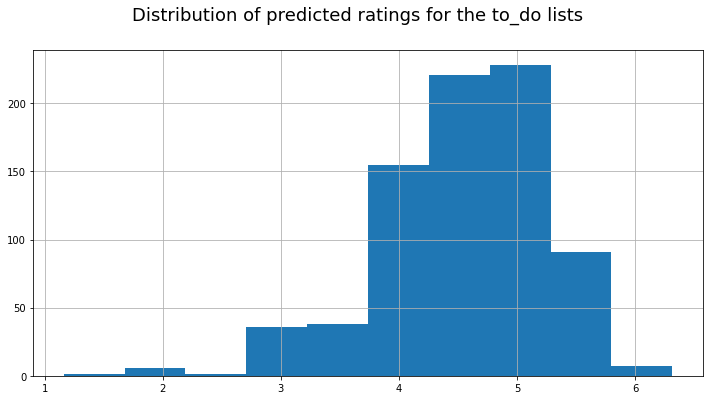

In [14]:
default_info = extracting_info_from_model(default_model)

Predictions
+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|  28767|     3| 3.3020515|
|    148|  29703|     4| 3.9060872|
|    148|  29031|     3|  3.352706|
|    148|  40167|     5| 3.9477775|
|    148|  27934|     4| 3.1927361|
|    148|  23576|     3| 2.9383779|
|    148|  45554|     4|  3.238894|
|    148|  33890|     3| 2.5839446|
|    148|  21658|     4| 3.4905386|
|    148|  47730|     2|  3.722455|
|    148|  14372|     3|  2.845519|
|    148|   5115|     4| 3.1627114|
|    148|   3005|     5|     3.934|
|    148|  45811|     3|  3.943457|
|    148|  31852|     3| 3.4553037|
|    463|  46147|     5|  4.013192|
|    463|  46479|     5|  3.946279|
|    463|   5152|     4| 3.8895242|
|    463|  17207|     4| 3.8959231|
|    463|   2619|     4|  3.371774|
+-------+-------+------+----------+
only showing top 20 rows

None
----------------------------------
ALS recommendations
+-------+--------------------+
|user_i

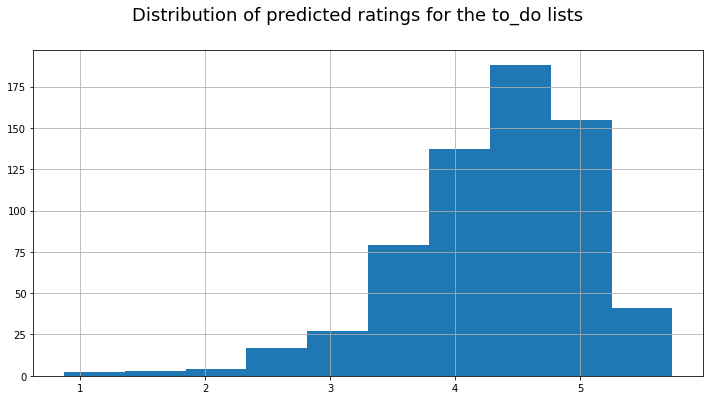

In [15]:
als_v2 = ALS(maxIter=10,regParam=0.05,rank=100, userCol="user_id",itemCol="book_id", ratingCol="rating",coldStartStrategy="drop",nonnegative=True, implicitPrefs = False)

tuned_model_v1 = als_v2.fit(training)

default_info = extracting_info_from_model(tuned_model_v1)

Predictions
+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|  28767|     3| 3.0764422|
|    148|  29703|     4|  3.731343|
|    148|  29031|     3| 3.4574728|
|    148|  40167|     5|  3.395949|
|    148|  27934|     4|  3.209757|
|    148|  23576|     3| 2.9445124|
|    148|  45554|     4| 3.5178013|
|    148|  33890|     3| 2.7549062|
|    148|  21658|     4| 3.3450587|
|    148|  47730|     2| 3.7743056|
|    148|  14372|     3| 3.2103539|
|    148|   5115|     4| 3.1830335|
|    148|   3005|     5| 3.9544237|
|    148|  45811|     3| 3.6733325|
|    148|  31852|     3| 3.2998128|
|    463|  46147|     5| 4.1218557|
|    463|  46479|     5|  4.026671|
|    463|   5152|     4| 3.9672134|
|    463|  17207|     4| 3.7547028|
|    463|   2619|     4| 3.5733774|
+-------+-------+------+----------+
only showing top 20 rows

None
----------------------------------
ALS recommendations
+-------+--------------------+
|user_i

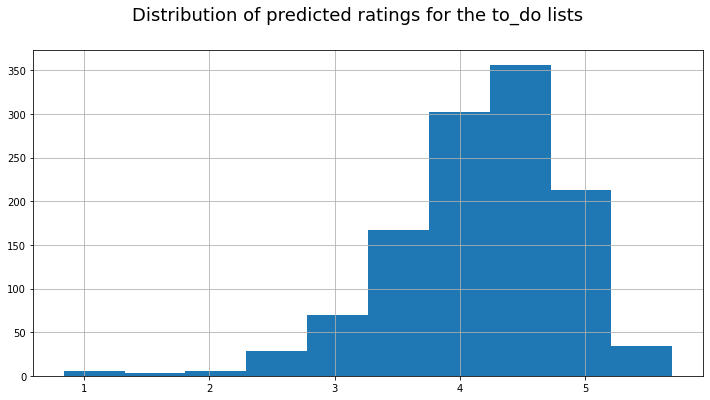

In [16]:
als_v3 = ALS(maxIter=20,regParam=0.15,rank=100, userCol="user_id",itemCol="book_id", ratingCol="rating",coldStartStrategy="drop",nonnegative=True, implicitPrefs = False)

tuned_model_v2 = als_v3.fit(training)

default_info = extracting_info_from_model(tuned_model_v2)